<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Multimodal_entailment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다중 모드 포함
- 내용 출처: [Multimodal entailment](https://keras.io/examples/nlp/multimodal_entailment/)
- 목표: 다중 모드 수반을 예측하기 위한 모델을 구축/훈련

## 01. 요구사항 설치

In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.6 MB 9.5 MB/s 
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 5.8 MB 26.3 MB/s 
     |████████████████████████████████| 1.6 MB 65.4 MB/s 
     |████████████████████████████████| 438 kB 45.7 MB/s 


## 02. 라이브러리 불러오기

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## 03. 레이블 맵 정의

In [3]:
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

## 04. 데이터세트 다운로드

In [4]:
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

344273442/344273442 [==============================] - 25s 0us/step


## 05. 데이터세트 전처리

In [5]:
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
897,1364034084293332992,JVGB loses to Winfield https://t.co/b7IdRaCWlz,http://pbs.twimg.com/media/Eu4FxOHWgAQtPid.jpg,1364035617080934407,VGB defeats Winfield https://t.co/8k64dftgbB,http://pbs.twimg.com/media/Eu4FdULXIAAw3HJ.jpg,NoEntailment
7,1354642121647665153,$BTC\n\nBreakout! Time to long the retest. Ent...,http://pbs.twimg.com/media/Esymv7nW8AYBUi6.jpg,1377375542555504647,UPDATE 5: I was wrong on the inverted hammer b...,http://pbs.twimg.com/media/Ex1rWafXMAYwgFy.png,NoEntailment
811,1330607439390060547,(#Qualifiers #QualifierNOR 🇳🇴 )\n\n🇳🇴 @Team_MX...,http://pbs.twimg.com/media/EndEYzZXcAAVkIr.jpg,1338214821968420866,(#Qualifiers #QualifierNOR 🇳🇴 )\n\n🇳🇴 @lag_dab...,http://pbs.twimg.com/media/EpJLRoZXEAE9Ho5.jpg,NoEntailment
289,1377557630852431875,How can social media and #NewsSentiment #data ...,http://pbs.twimg.com/media/Ex4RXZ2WgAIukTc.jpg,1381483482883485697,What did a white paper from Probability and Pa...,http://pbs.twimg.com/media/EywD6EJXIAMpdbF.jpg,NoEntailment
336,1363293787775197187,Round 3 Pairings at the 3-C #AMTARegionals #Ro...,http://pbs.twimg.com/media/EutkeWMXcAIgFmp.jpg,1370908576387104770,Round Three Pairings at the 1-C #AMTAORCS #Roa...,http://pbs.twimg.com/media/EwZyFZ6WUAE1u32.jpg,NoEntailment
783,1377855525707149312,@Reuters Shortlived. That is a rejection candl...,http://pbs.twimg.com/media/Ex8gTEMUcAUPilw.jpg,1382014280506224642,$LINK won’t be below this line much longer htt...,http://pbs.twimg.com/media/Ey3mqYvWYBAqFM9.jpg,NoEntailment
915,1358754997018767361,Good morning #TriCities! Currently it is 22℉ a...,http://pbs.twimg.com/media/EttEeDmXUAEz2Bh.jpg,1358898589297221634,Good evening #TriCities! Currently it is 54℉ a...,http://pbs.twimg.com/media/EtvHEO-WgAUGvB3.jpg,NoEntailment
1369,1371144717241622528,This was an AMAZING Stream today!\nBig thanks ...,http://pbs.twimg.com/media/EwdHDQ8XEAM44ac.jpg,1382092282556522501,"another fucking insane stream man, big shout o...",http://pbs.twimg.com/media/Ey4tY03XIAEA0sc.png,NoEntailment
1285,1366353801679167496,Check out our live in-person fitness classes t...,http://pbs.twimg.com/media/EvZDiqvXIAQXDMi.jpg,1367808394195828740,Another week of live in-person fitness classes...,http://pbs.twimg.com/media/EvtufGuXIAIf_kT.jpg,NoEntailment
1083,1359121217173610504,"""ನಂದಾದೀಪ""\nLiving up to the legacy .\n\nWatch ...",http://pbs.twimg.com/media/EtyRixhU0Ac7VD4.jpg,1361662126675292160,Sons of villains..\nStar directors..\nBrothers...,http://pbs.twimg.com/media/EuWYfMaUYAk2ii0.jpg,NoEntailment


In [6]:
# 수반 작업은 다음과 같이 공식화된다
# (text_1, image_1) 및 (text_2, image_2)쌍이 주어졌을 때 서로를 수반(또는 수반하거나 모순되지 않음)하는가?

images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

df["label_idx"] = df["label"].apply(lambda x: label_map[x])

## 06. 데이터 시각화

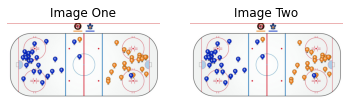

Text one: Final shot locations vs Stockton. #Marlies 26 -24 edge. 4-3 final score Toronto W https://t.co/nBNRzXoYD2
Text two: Final shot locations vs Laval #Marlies 22 Rocket 28 Final score 4-3 Laval. https://t.co/66opEPkvoH
Label: NoEntailment


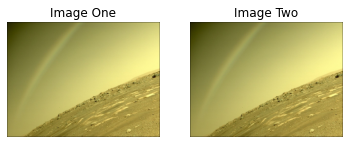

Text one: No, the Perseverance rover didn't spot a rainbow on Mars https://t.co/o5Sex9xAQo https://t.co/lMOiPD7cwr
Text two: 😂 #spaceisfake there are no rainbows on Mars https://t.co/zODHDpf4IX
Label: NoEntailment


In [7]:
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")


random_idx = np.random.choice(len(df))
visualize(random_idx)

random_idx = np.random.choice(len(df))
visualize(random_idx)

## 07. 훈련/평가 데이터 분할

In [8]:
# 라벨 개수 확인
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

In [9]:
# 데이터 분할
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


## 08. 데이터 입력 파이프라인

In [10]:
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

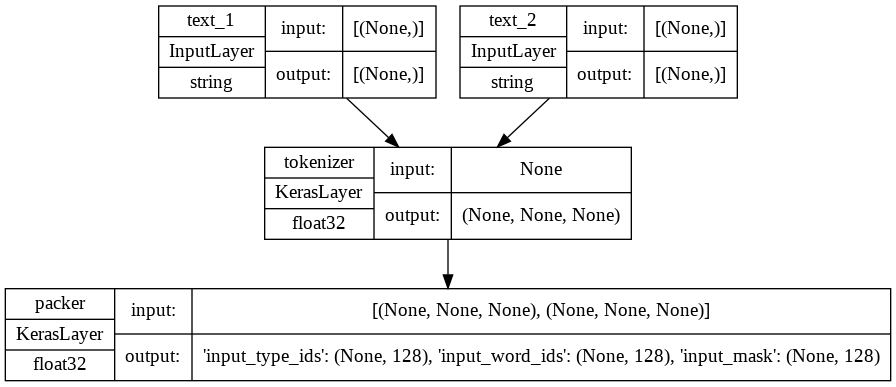

In [11]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    truncated_segments = segments

    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model(["text_1", "text_2"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

## 09. 데이터 전처리

In [12]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Text 1: ➡️Day 1 of Video Compliance Camp is on December 15 and you can earn up to 4 Sub. and 2 Ethics Credits.⬅️
Email to register: cle@lehighbar.org
Visit https://t.co/fho29W48h1 for more info. 

#balc #ncba #cle #compliance #ethicscredits https://t.co/PPYTiGggzW
Text 2: ✌️Day 2 of Video Compliance Camp is on December 17 and you can earn up to 4 Sub. and 2 Ethics Credits.📽️
Email to register: cle@lehighbar.org
Visit https://t.co/fho29W48h1 for more info. 

#balc #ncba #cle #compliance #ethicscredits https://t.co/VhipSHktYi
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101   100  1015  1997  2678 12646  3409  2003  2006  2285  2321  1998
  2017  2064  7796  2039], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), 

In [13]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [14]:
# 전처리 유틸리티
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

In [15]:
# 최종 데이터세트 생성
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

## 10. 모델 구축 유틸리티

In [16]:
# 프로젝션 유틸리티
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [17]:
# 비전 인코더 유틸리티
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):

    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

In [18]:
# 텍스트 인코더 유틸리티
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    bert.trainable = trainable

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    embeddings = bert(inputs)["pooled_output"]

    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    return keras.Model(inputs, outputs, name="text_encoder")

94668760/94668760 [==============================] - 1s 0us/step


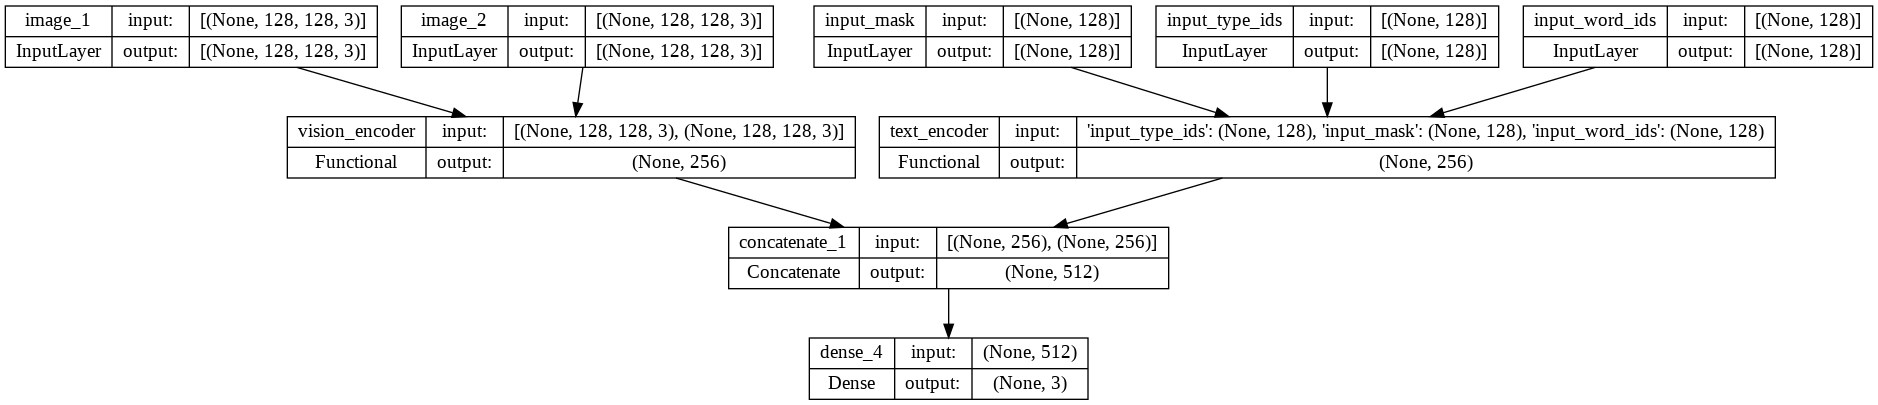

In [19]:
# 다중 모드 모델 유틸리티
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

## 11. 모델 컴파일 및 학습

In [20]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
38/38 [==============================] - 165s 4s/step - loss: 0.6409 - accuracy: 0.8471 - val_loss: 0.5471 - val_accuracy: 0.8571
Epoch 2/10
38/38 [==============================] - 127s 3s/step - loss: 0.3596 - accuracy: 0.8864 - val_loss: 0.6041 - val_accuracy: 0.8571
Epoch 3/10
38/38 [==============================] - 124s 3s/step - loss: 0.2628 - accuracy: 0.9131 - val_loss: 0.7940 - val_accuracy: 0.8413
Epoch 4/10
38/38 [==============================] - 125s 3s/step - loss: 0.1692 - accuracy: 0.9407 - val_loss: 1.0259 - val_accuracy: 0.8254
Epoch 5/10
38/38 [==============================] - 125s 3s/step - loss: 0.2014 - accuracy: 0.9323 - val_loss: 1.0779 - val_accuracy: 0.7143
Epoch 6/10
38/38 [==============================] - 125s 3s/step - loss: 0.2456 - accuracy: 0.9256 - val_loss: 0.7618 - val_accuracy: 0.8571
Epoch 7/10
38/38 [==============================] - 125s 3s/step - loss: 0.1027 - accuracy: 0.9666 - val_loss: 1.0669 - val_accuracy: 0.8413
Epoch 8/10
38

## 12. 모델 평가

In [21]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 22s 3s/step - loss: 0.9850 - accuracy: 0.8500
Accuracy on the test set: 85.0%.
